In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Author: abdoulsn

import itertools
import os
import glob
import scipy
import pathlib
import csv
import numpy as np
import pandas as pd
import soundfile
import librosa
import librosa.display
import IPython.display as ipd

# utils
from joblib import dump, load

from prepare_data import load_data # Ma methode load_data est dans prepare_data.py
from prepare_data import echantillons # Ma methode echantillons  est dans prepare_data.py
from utils import plot_confusion_matrix # j'ai defini une function dasn utils.py (source sklearn)

from PIL import Image
from scipy import io
from scipy.io import wavfile
from matplotlib.pyplot import specgram
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

## Intro

Pour déterminer le genre de musique d'un morceau de musique, un certain nombre de variables basées sur le contenu sont d'abord extraites. En général, les fonctionnalités utilisées pour la classification de la musique peuvent être grossièrement classées en trois classes: la texture timbrale, les caractéristiques rythmiques et les caractéristiques de contenu de hauteur(pitch).

Les caractéristiques du timbre sont généralement caractérisées par les propriétés liées aux instrumentations ou aux sources sonores telles que la musique, la parole ou les signaux d'environnement. Les variables utilisées pour représenter la texture timbrale d'une piste musicale comprennent le zero crossing(le nombre de fois qu'un signal à traversé la barre horizontale à zéro), le centroïde spectral, le flux spectral, spectral rolloff, les coefficients cepstraux de fréquence Mel (MFCCs), etc.

[stanford docs](http://cs229.stanford.edu/proj2017/final-posters/5142012.pdf)

## Chapitre
0. Chargement des données
1. Exploration
2. Extraction des features
3. Data processing (red dim, stats desc)
4. Application de logistic_reg (model+OneVsrest+roc)
5. Application de SVM (Modele+matrice de conf+roc_auc)
6. Résultats
7. Source of code (if copied)

## Construction de la base de données

Nous allons utiliser l'un des jeux de données les plus connus dasn la reconnaissance de genre musicale, le GTZAN. L'ensemble de données a été développé par [ G. Tzanetakis and P. Cook in IEEE in 2002](http://marsyas.info/downloads/datasets.html) avec des chansons collectées à partir de sources multiples comme les CD et la radio. L'ensemble de données se compose de 1000 fichiers audio bruts au format .wav, d'une durée de 30 secondes chacun.  



L'audio est organisé en 10 genres musicaux, chaque genre avec 100 échantillons. Dans cet ensemble de données, nous avons une fréquence d'échantillonnage de 22050 Hz, un seul canal (mono) et 16 bits pour la quantification. Les genres sont: Metal, Disco, Classique, Hiphop, Jazz, Country, Pop, Blues, Reggae et Rock.

In [6]:
# Extraction des labels et des noms de fichier puis les enregistrer dans un dictionnaire
genres = []
path_audios = []
dirs = '../data_in/*/*'
for i in glob.glob(dirs):
    if glob.glob(i)[0][-4:] == ".wav":
        path_audios.append(i,)
        genres.append([i][0].split("/")[3].split(".")[0])


## EDA 

In [7]:
sample = dict(zip(genres, path_audios))

In [8]:
import random
_, value = random.choice(list(sample.items()))
print(_)
ipd.Audio(value)

blues


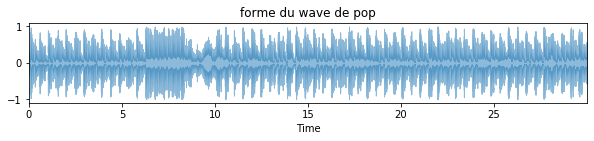

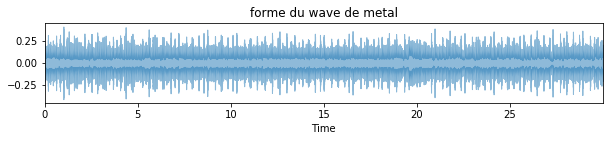

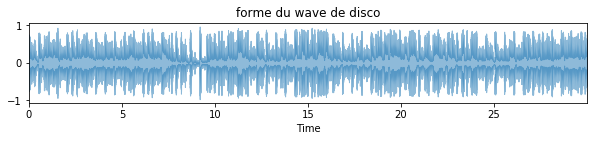

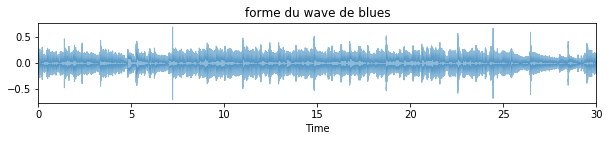

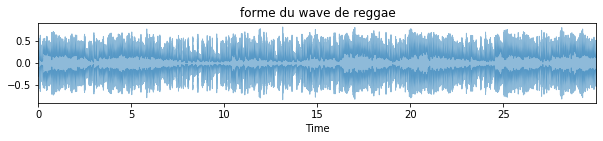

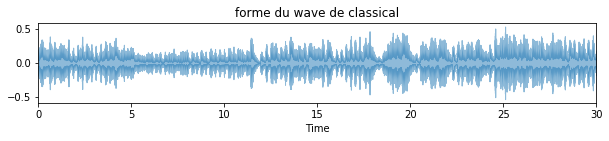

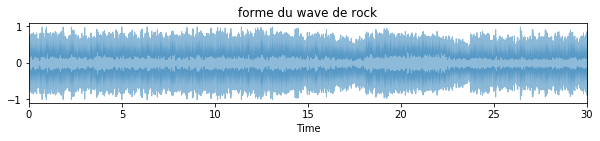

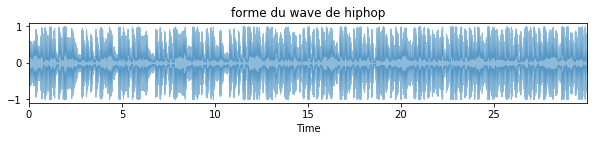

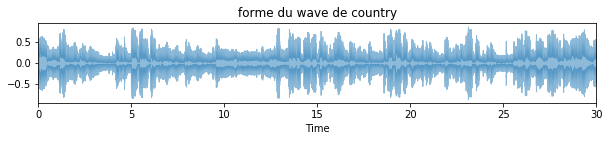

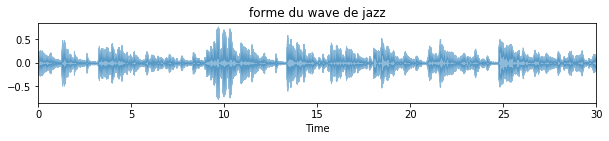

In [9]:
for genre, audio in sample.items():
    plt.figure(figsize=(10,5))
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(librosa.load(audio)[0], alpha=0.5)
    plt.title("forme du wave de "+genre)

## [Features extraction](https://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_43_v2.pdf)
Chaque signal audio comprend de nombreuses variables. Cependant, nous devons extraire les variables qui sont pertinentes pour le problème que nous essayons de résoudre. Dans notre cas la reconnaissance du genre musicale.

initialement: zero_crossing, chroma freq, mfccs, rmse, amplitude envel, spectrale_centroid, spec rollof, 

#### Params fenetrage, deplacement (hope_len), sample rate.

In [11]:
n_fft = 1024
hop_length = 512

### 1. Extraction nuérique à partir de LibRosa

Dans ce projet, nous allons extraire des varaibles de timbre à partir de petites fenêtres de l'audio brute (généralement on utilise des fenêtres de 10 ms). L'idée de calculer chaque caractéristique à partir de ce signal fenêtré est de supposer la **stationnarité** dans cette petite fenêtre. la taille de la fenetre est 1024 et le déplacement de cette fenetre s'emboite à moitié d'ou les 512.

Référence how to ==> [Comment extraire les feature via librosa: LibRosa Docs](https://librosa.org/doc/latest/feature.html)

In [21]:
file = open('../data_out/rawdata2.csv', 'w', newline='')

# Initialisation des noms de colonnes à extraires
header = 'contrast rmse centroid bandwidth rolloff zero_crossing_rate' # rm filename
for i in range(1, 14): # Pour le mfcc nous en avons 13 on cree 13 noms de colonnes ici
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# initialisation du fichier de données
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split() # les 10 genres de musics

# Extraction des features par boucle
for g in genres:
    for filename in os.listdir(f'../data_in/{g}'):
        songname = f'../data_in/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True) # Données brutes et sampling_rate
        contrast = librosa.feature.spectral_contrast(y, sr=sr)
        rmse = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
        
        # La moyenne des valeurs sur une fichiers audioos données
        to_append = f'{np.mean(contrast)} {np.mean(rmse)} {np.mean(centroid)} {np.mean(bandwidth)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('../data_out/rawdata2.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

### 2. Statistiques des différentes genres de musics pour quelques variables

In [2]:
### 1. Preparation des données (échantillons, normalisation, réduction de dimmension)
X_train, y_train, X_test, y_test = echantillons("../data_out/rawdata2.csv", test_size=0.1,)

Échnatillon crées vous avez X et y!


Echantillons x_train, y_train, X_validation, y_validation, X_test, y_test crées.


In [99]:
X_train.sample(3)

,contrast,rmse,centroid,bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
592,21.463201,0.043128,1692.458032,1955.532123,3600.491453,0.072363,-309.454773,117.662910,-12.889459,47.995052,-12.674720,19.030447,-13.246973,15.962363,-17.035479,13.927606,-5.603896,9.268923,-6.430809
314,22.007796,0.117573,2060.626577,2145.524417,4348.058317,0.100235,-173.499207,112.607246,-24.938351,36.852341,-9.767525,28.432135,-14.252284,20.776697,-19.151279,18.974108,-15.471505,9.349363,-13.030901
455,18.548794,0.180530,2579.023929,2867.250191,5649.137962,0.111511,-200.742371,78.675011,32.041035,11.890013,4.060291,5.559170,5.417686,-1.014906,1.220928,2.378663,2.834867,1.299022,-0.652841


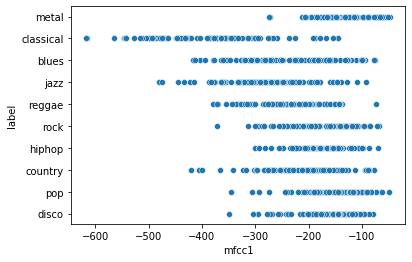

In [100]:
import seaborn as sns
sns.scatterplot(x=X_train['mfcc1'], y=y_train)

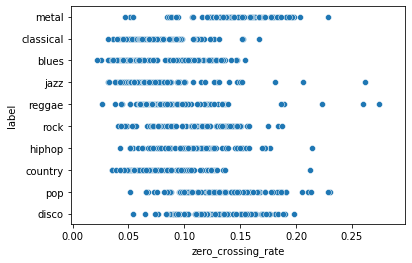

In [101]:
sns.scatterplot(x=X_train['zero_crossing_rate'], y=y_train)

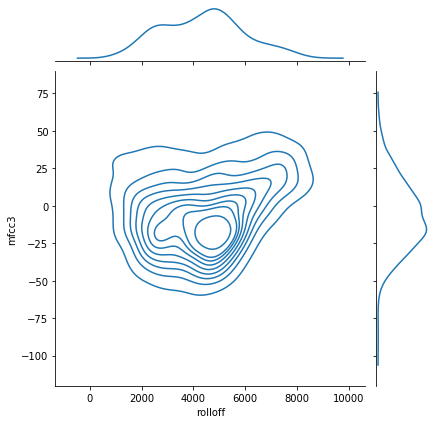

In [102]:
sns.jointplot(x=X_train['rolloff'], y=X_train['mfcc3'], kind="kde")

## Apprentissage avec SVM

In [3]:
# recodage pour le fit()
y_train = y_train.astype('category')
y_train = y_train.cat.codes
y_test = y_test.astype('category')
y_test = y_test.cat.codes

# Normalisation avec stdslr
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#Appliqué le meme sur le test aussi
X_test_scaled = scaler.transform(X_test)

### Vérification de l'importance des variables avec RandomForest

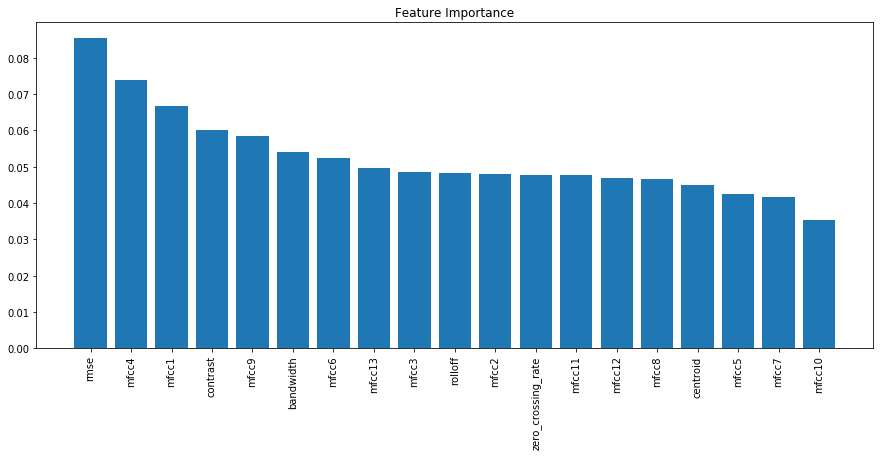

In [104]:

# L'importance des variables
clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns.values[i] for i in indices]
plt.figure(figsize=(15,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

On garde toutes les variables.

## 2. Logistic Regression
Nous allons utiliser le gridsearch pour definir les meilleur parametres du modele.

In [4]:
#intance du modele svc en logistic
lg = LogisticRegression()

#defiiton du dico des parametres pour l'optimisation
parameters = {"C": [0.01, 0.4, 1, 10, 30, 80, 100, 150, 180, 200],
              'solver' : ['lbfgs', 'liblinear'],
              "max_iter":[1000, 2000]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)
logreg = GridSearchCV(lg, parameters, scoring=scorer, n_jobs=-1,cv=5, verbose=1)
logreg.fit(X_train_scaled, y_train)
print("\n fin du run de GridSearchCV \n")


#print le résultats de l'optimisation
def display(results):
    print(f'Meilleurs parameters: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + ou -{round(std,2)} pour le {params}')

display(logreg)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s



 fin du run de GridSearchCV 

Meilleurs parameters: {'C': 100, 'max_iter': 1000, 'solver': 'liblinear'}


-10.008 + ou -0.66 pour le {'C': 0.01, 'max_iter': 1000, 'solver': 'lbfgs'}
-9.736 + ou -1.1 pour le {'C': 0.01, 'max_iter': 1000, 'solver': 'liblinear'}
-10.008 + ou -0.66 pour le {'C': 0.01, 'max_iter': 2000, 'solver': 'lbfgs'}
-9.736 + ou -1.1 pour le {'C': 0.01, 'max_iter': 2000, 'solver': 'liblinear'}
-9.423 + ou -0.62 pour le {'C': 0.4, 'max_iter': 1000, 'solver': 'lbfgs'}
-8.836 + ou -1.03 pour le {'C': 0.4, 'max_iter': 1000, 'solver': 'liblinear'}
-9.423 + ou -0.62 pour le {'C': 0.4, 'max_iter': 2000, 'solver': 'lbfgs'}
-8.836 + ou -1.03 pour le {'C': 0.4, 'max_iter': 2000, 'solver': 'liblinear'}
-9.206 + ou -0.69 pour le {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
-8.891 + ou -0.96 pour le {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
-9.206 + ou -0.69 pour le {'C': 1, 'max_iter': 2000, 'solver': 'lbfgs'}
-8.891 + ou -0.96 pour le {'C': 1, 'max_iter': 2000, 'solver'

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.1s finished


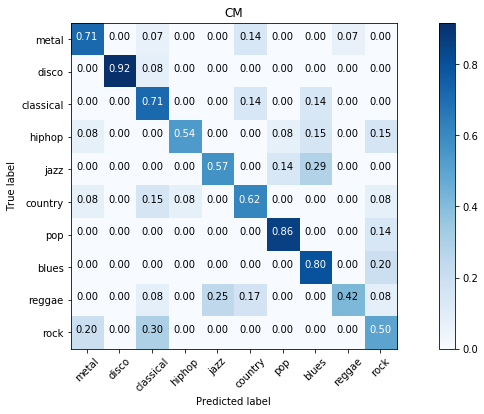

<Figure size 1080x432 with 0 Axes>

In [6]:
#Utilisons ici les params donnés par gridserchcv
grid_logreg = LogisticRegression(C=100, max_iter=1000, solver="liblinear")
grid_logreg.fit(X_train_scaled, y_train)
y_predlog = grid_logreg.predict(X_test_scaled)

# plot de la conf matrice
cm = confusion_matrix(y_test, y_predlog)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

plot_confusion_matrix(cm, classes, normalize=True, )

In [7]:
from sklearn.metrics import accuracy_score
print("Le score de accuracy est {}%".format(accuracy_score(y_test, y_predlog)*100))

Le score de accuracy est 65.0%


In [22]:
dump(grid_logreg, "../data_out/grid_log.joblib")

['../data_out/grid_log.joblib']

# Courbe de ROC Lohgistique regression
### Pour ce faire on doit convertir le probleme à ONEvsRest

In [21]:
# classifier
clf = OneVsRestClassifier(grid_logreg)
y_score = clf.fit(X_train_scaled, y_train).decision_function(X_test_scaled)

#### plot de auc_roc

In [71]:
# voir référence pour la source du code
def plot_multiclass_roc(clf, X_test , y_test, y_score, n_classes, figsize=(15,6)):
    """
    input: clf, X_test , y_test, y_score, n_classes, figsize=(15,6)
    Output: le plot des différents courbes de roc
    """
    y_score = y_score

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Faux Positive')
    ax.set_ylabel('Vrai Positive')
    ax.set_title('Courbe de ROC')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

[(0, 'metal'), (1, 'disco'), (2, 'classical'), (3, 'hiphop'), (4, 'jazz'), (5, 'country'), (6, 'pop'), (7, 'blues'), (8, 'reggae'), (9, 'rock')]


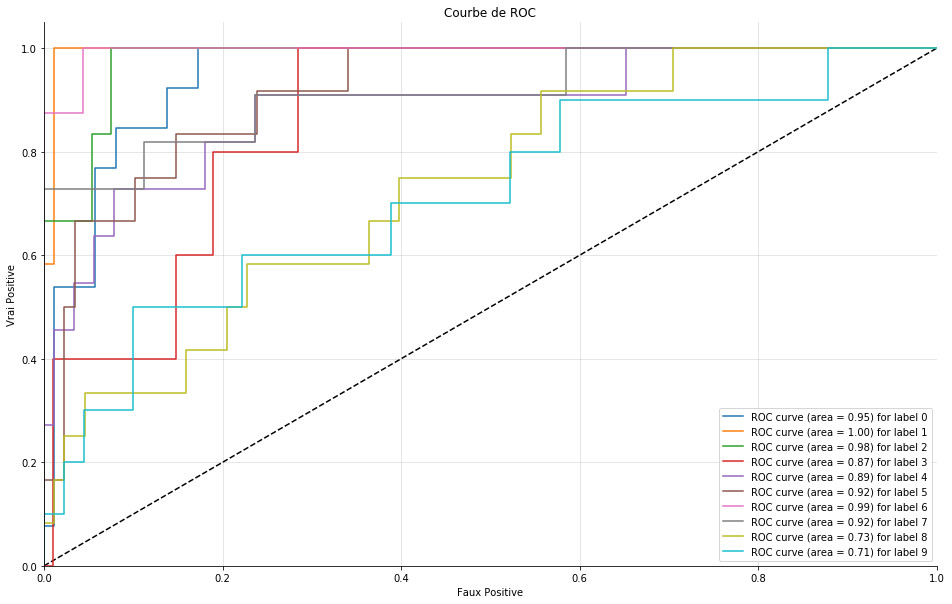

In [75]:
print([(i, j) for i, j in enumerate(classes)])
plot_multiclass_roc(grid_logreg, X_test, y_test, y_score, n_classes=10, figsize=(16, 10))

Ce modèle de regression logistique arrive à bien classer les genres sauf 2, `raggae`et `rock`.

#### Appliquons un svm pour si on aura de meilleurs performance.

## SVM

#### Creation du modele et train du svm et recherche de parametres

In [31]:
#intance du modele svc en svm
SVC_M = SVC()
#defiiton du dico des parametres pour l'optimisation
parameters = {"gamma" : [0.001, 0.01, 0.1, 0.4, 1, 1.5, 5],
              "kernel" : ['poly', 'rbf', 'linear'],
              "degree" : [1, 2],
              "C": [0.01, 0.1, 0.4, 1, 10, 20, 50, 100, 200]}


scorer = make_scorer(mean_squared_error, greater_is_better=False)
svm_grid = GridSearchCV(SVC_M, parameters, scoring=scorer, n_jobs=-1,cv=5, verbose=1)

svm_grid.fit(X_train_scaled, y_train)

print("\n Gridsearch à fini \n print des meilleurs parametres \n")

#print le résultats de l'optimisation
def display(results):
    print(f'Meilleurs parameters: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + ou -{round(std,3)} pour le {params}')

display(svm_grid)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1446 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:   50.5s



 Gridsearch à fini 
 print des meilleurs parametres 

Meilleurs parameters: {'C': 200, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


-10.492 + ou -0.186 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}
-10.493 + ou -0.188 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-12.006 + ou -0.822 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}
-10.492 + ou -0.186 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}
-10.526 + ou -0.249 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-12.006 + ou -0.822 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear'}
-9.901 + ou -0.516 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
-10.621 + ou -0.436 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
-12.006 + ou -0.822 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
-11.66 + ou -1.01 pour le {'C': 0.01, 'degree': 1, 'gamma': 0.4, 'kernel': 'poly'}
-10.91

[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  1.1min finished


### Parametre retenus:
Meilleurs parameters: {'C': 200, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}

#### Entrainement avec les parametre optimisé

<Figure size 720x720 with 0 Axes>

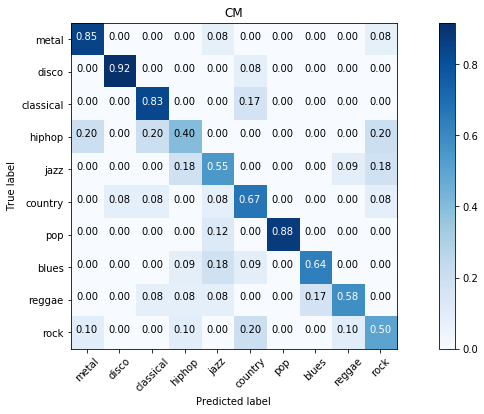

<Figure size 1080x432 with 0 Axes>

In [32]:
#Utilisons ici les params donnés par gridserchcv
grid_svm = SVC(C=200, degree=1, gamma=.1, kernel='rbf', random_state=124) # , C=100, degree=3, gamma=1, kernel='poly'
grid_svm.fit(X_train_scaled, y_train)
y_predsvm = grid_svm.predict(X_test_scaled)

# plot de la conf matrice
cm = confusion_matrix(y_test, y_predsvm)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [33]:
dump(grid_svm, "../data_out/grid_svm.joblib")
print("Le score de accuracy est {}%".format(accuracy_score(y_test, y_predsvm)*100))

Le score de accuracy est 69.0%


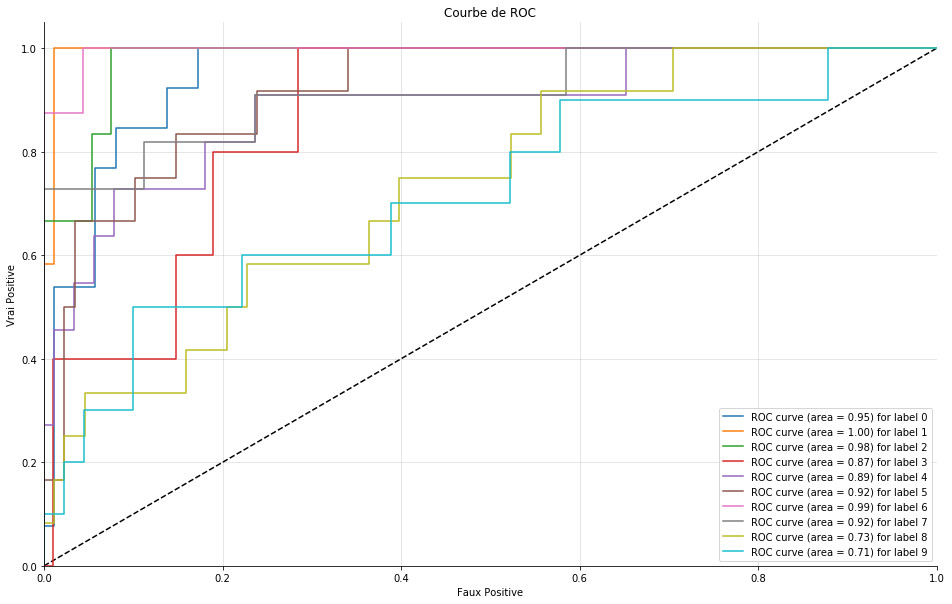

In [34]:
plot_multiclass_roc(grid_svm, X_test, y_test, y_score, n_classes=10, figsize=(16, 10))

### Logistique regression: 65% de précision
### Support vector machine: 69% de précision
Le svm s'est quasiment comporté en terme de classification des genre de la meme facns que la logistique régresion.

## Réferences

#### plot_multiclass_roc : https://stackoverflow.com/a/59326862/8333806
#### Librosa feature extraction: https://librosa.org/doc/latest/feature.html

## Réferences

#### plot_multiclass_roc : https://stackoverflow.com/a/59326862/8333806
#### Librosa feature extraction: https://librosa.org/doc/latest/feature.html